# Identify School Deficit Hotspots in Florianopolis

Load data and geospatial libraries

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import urbanpy as up
import h3
import libpysal
import contextily as ctx
from esda.getisord import G_Local

Load hexagon data for Florianopolis

In [248]:
hex_df = pd.read_parquet("outputs/31102023_flor_hexs_final.parquet")

In [249]:
hex_df.head()

,hex,population_2020,pop_3_5_years_adj,pop_6_14_years_adj,pop_15_17_years_adj,pop_18_years_adj,V002_adj,V003_adj,income_pc,ensino_fundamental,...,matric_oficial_educacao_jovens_adultos,matric_oficial_educacao_profissional,matric_oficial_no_specified,diff_pop_matric_total_ensino_fundamental,rate_pop_matric_total_ensino_fundamental,diff_pop_matric_total_educacao_infantil,rate_pop_matric_total_educacao_infantil,diff_pop_matric_total_ensino_medio,rate_pop_matric_total_ensino_medio,urban_area
0,88a91bcd09fffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,88a91bcd51fffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,88a91b425bfffff,19.249137,0.850062,0.289021,0.085006,0.017001,2.765534,2351.599442,850.32377,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,88a91b5565fffff,9.624569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,88a91b4d57fffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [250]:
sc_munis = gpd.read_file("outputs/flor_muni.geojson", driver="GeoJSON")
flor_muni = sc_munis.query("code_muni == 4205407")

In [251]:
flor_hexs = up.geom.gen_hexagons(resolution=8, city=flor_muni)

In [252]:
flor_hexs.head()

,hex,geometry
0,88a91bcd09fffff,"POLYGON ((-48.50489 -27.84191, -48.50072 -27.8..."
1,88a91bcd51fffff,"POLYGON ((-48.52335 -27.84365, -48.51917 -27.8..."
2,88a91b5565fffff,"POLYGON ((-48.46642 -27.70402, -48.46224 -27.7..."
3,88a91b425bfffff,"POLYGON ((-48.46311 -27.69699, -48.45893 -27.6..."
4,88a91b4d57fffff,"POLYGON ((-48.35799 -27.49173, -48.35381 -27.4..."


In [253]:
hex_df.shape, flor_hexs.shape

((989, 38), (989, 2))

In [254]:
hex_gdf = flor_hexs.merge(hex_df, on="hex", how="left")

Calculate Hotspots 

Remove disconnected hexagons

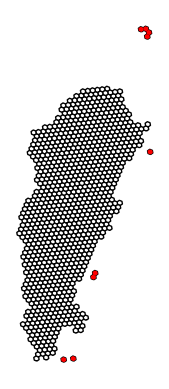

In [255]:
# Select disconnected hexagons
disconnected_hexs = [0, 1, 2, 3, 4, 985, 986, 987, 988]

ax = hex_gdf.plot(facecolor="white", edgecolor="black")
hex_gdf.loc[disconnected_hexs, "geometry"].plot(color="red", ax=ax)
ax.set_axis_off()
# Add index text in red text
# for idx, row in hex_gdf.reset_index().iterrows():
# plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['index'], color='red')

In [256]:
hex_gdf = hex_gdf.drop(disconnected_hexs, axis=0)

Define variables to be used in the analysis

In [257]:
print(hex_gdf.columns)

Index(['hex', 'geometry', 'population_2020', 'pop_3_5_years_adj',
       'pop_6_14_years_adj', 'pop_15_17_years_adj', 'pop_18_years_adj',
       'V002_adj', 'V003_adj', 'income_pc', 'ensino_fundamental',
       'educacao_infantil', 'ensino_medio', 'educacao_jovens_adultos',
       'educacao_profissional', 'no_specified', 'publica', 'privada',
       'Matriculas totales', 'Matrículas oficiales',
       'matric_total_ensino_fundamental', 'matric_total_educacao_infantil',
       'matric_total_ensino_medio', 'matric_total_educacao_jovens_adultos',
       'matric_total_educacao_profissional', 'matric_total_no_specified',
       'matric_oficial_ensino_fundamental', 'matric_oficial_educacao_infantil',
       'matric_oficial_ensino_medio', 'matric_oficial_educacao_jovens_adultos',
       'matric_oficial_educacao_profissional', 'matric_oficial_no_specified',
       'diff_pop_matric_total_ensino_fundamental',
       'rate_pop_matric_total_ensino_fundamental',
       'diff_pop_matric_total_educac

In [258]:
features_names = [
    "population_2020",
    "pop_6_14_years_adj",
    "ensino_fundamental",
    "matric_total_ensino_fundamental",
    "income_pc",
    "publica",
    "urban_area",
]

features_weights = [0.1, 0.1, 0.2, 0.2, 0.1, 0.1, 0.2]

kring = 3  # Number of neighbors to consider

significance = 0.05  # Statistical significance level

In [259]:
try:
    assert np.array(features_weights).sum() == 1.0
except AssertionError as e:
    e.args += ("Features weights must sum to 1.0",)
    raise e

In [260]:
hex_gdf[analysis_cols].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
population_2020,512.0,998.29,1733.86,0.0,59.06,300.18,1202.87,14656.53
pop_6_14_years_adj,512.0,142.09,235.87,0.0,2.05,33.04,179.22,1302.00
ensino_fundamental,132.0,0.89,0.82,0.0,0.00,1.00,1.00,5.00
matric_total_ensino_fundamental,137.0,532.81,867.94,0.0,0.00,253.00,741.00,6919.00
income_pc,470.0,1240.73,693.71,0.0,797.26,1027.32,1507.78,3948.38
publica,132.0,1.23,1.07,0.0,0.00,1.00,2.00,5.00
urban_area,980.0,0.15,0.36,0.0,0.00,0.00,0.00,1.00


In [261]:
def minmax_scaler(col, a=0, b=1):
    """
    Min-max scaler

    Parameters
    ----------
    col : pandas.Series
        Series to be scaled
    a : float, optional
        Min value of the scaled Series. Default is 0.
    b : float, optional
        Max value of the scaled Series. Default is 1.

    Returns
    -------
    pandas.Series
        Scaled Series
    """
    return (col - col.min()) * (b - a) / (col.max() - col.min()) + a


def linear_combination(x, w):
    """
    Linear combination of features

    Parameters
    ----------
    row : pandas.Series
        Series with features to be combined
    weights : list
        List of weights for each feature

    Returns
    -------
    float
        Linear combination of features
    """
    return np.dot(x, w)

Handle missing values

In [262]:
hex_df_clean = (
    hex_gdf[features_names].fillna(0)
    # .filllna(subset=["population_2020"]) # Drop rows with missing values
    # .apply(lambda col: col.fillna(col.mean()), axis=0) # Fill missing values with mean
)

Create a new column with the weighted sum of mix-max scaled features

In [263]:
hex_df_clean["score"] = hex_df_clean.apply(
    minmax_scaler, axis=0
).apply(  # Make columns values between 0 and 1
    linear_combination, w=features_weights, axis=1
)  # Row-wise linear combination

In [264]:
hex_df_clean = hex_df_clean.merge(
    hex_gdf[["hex", "geometry"]], left_index=True, right_index=True
)
hex_gdf_clean = gpd.GeoDataFrame(hex_df_clean, geometry="geometry", crs=hex_gdf.crs)

Calculate spatial weights matrix

In [265]:
# https://gist.github.com/darribas/c909209bc58fc0deddf46d8ec8fce6d0
def w_from_hids(hids, kring=1):
    """
    Create a spatial weights matrix from a list of hexagons and a k-ring

    Parameters
    ----------
    hids : list
        List of hexagons ids
    kring : int, optional
        Number of rings to be considered. Default is 1.

    Returns
    -------
    pysal.lib.weights.W
        Spatial weights matrix

    """
    shids = set(hids)
    neis = {}
    for hid in hids:
        neis[hid] = list(h3.k_ring(hid, kring).intersection(shids))
    w = libpysal.weights.W(neis, id_order=hids, ids=hids)
    return w

Generate spatial weights matrix with kring neighbors

In [266]:
w_h3_k3 = w_from_hids(hex_df_clean.hex.tolist(), kring=kring)

Calculate Gi* statistic for our score variable

In [267]:
lg_h3_k3 = G_Local(hex_gdf_clean["score"], w_h3_k3)

Get the number of significant hexagons

In [268]:
(lg_h3_k3.p_sim < significance).sum()

584

Assing Gi* and p-value to hexagons

In [269]:
hex_gdf_clean["Gi_h3_k3"] = lg_h3_k3.Gs
hex_gdf_clean["p_sim_h3_k3"] = lg_h3_k3.p_sim

In [270]:
hex_gdf_clean["Gi_h3_k3"].describe()

count    980.000000
mean       0.001026
std        0.000985
min        0.000000
25%        0.000287
50%        0.000741
75%        0.001434
max        0.005492
Name: Gi_h3_k3, dtype: float64

Visualize the local G index after filtering not significant and unpopulated hexagons. Higher values indicate a hotspot.

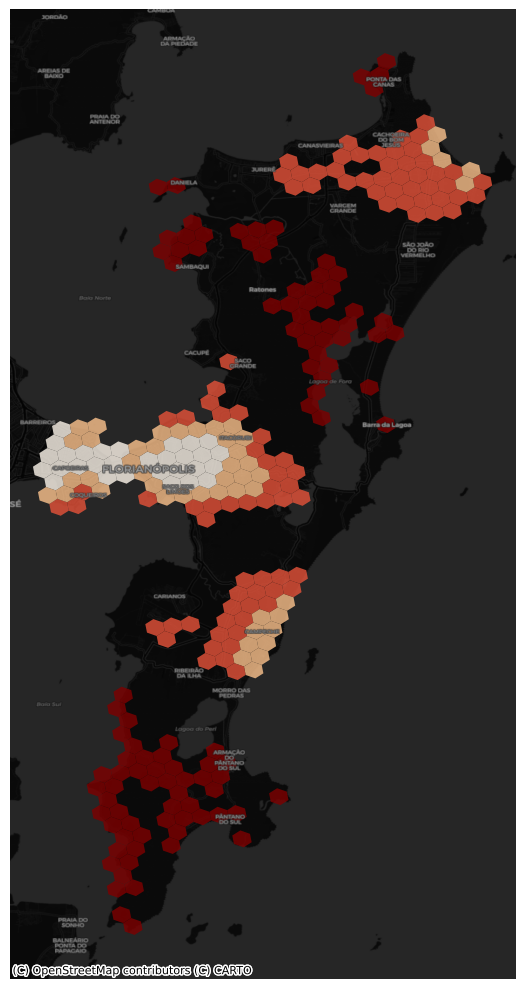

In [274]:
fig, ax = plt.subplots(figsize=(12, 10))
(
    hex_gdf_clean.query("p_sim_h3_k3 < 0.05")
    .query("population_2020 > 0")
    .plot(column="Gi_h3_k3", cmap="OrRd_r", scheme="FisherJenks", k=4, ax=ax, alpha=0.8)
)

ax.set_axis_off()

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.DarkMatterNoLabels,
    crs=hex_gdf_clean.crs.to_string(),
)
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.DarkMatterOnlyLabels,
    crs=hex_gdf_clean.crs.to_string(),
)

plt.tight_layout()

# Remove figure white border
plt.savefig(
    "outputs/maps/flor/11-flor-hotspots.png", bbox_inches="tight", pad_inches=0, dpi=300
)

plt.show()